Evaluate parameter convergence and effect of regularisation.

In [1]:
from pathlib import Path
import sys
import pandas as pd
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import pypesto 
import pypesto.store
from pypesto.visualize import create_references
import pypesto.visualize as vis

dir_pipeline = Path(".").resolve().parents[1]
dir_1 = dir_pipeline / "1_mechanistic_model"
dir_5 = dir_pipeline / "5_optimisation"
dir_6 = Path(".").resolve().parent
sys.path.append(str(dir_1))
sys.path.append(str(dir_6))

from helpers_ruoff import (
    load_exp_summary, 
    inverse_transform, 
    load_opt_parameters,
)

In [2]:
## manual setting ##
problem_name = "ruoff_atp_consumption"
experiment_name_grid = "2024_07_22_Ruoff_Grid"
experiment_name_25 = "2024_08_13_Ruoff_Grid"
CLUSTER = False

In [3]:
from reference_ruoff import PARAMETERS_IDS
with open(dir_pipeline / "problems.json", "r") as f:
    problem = json.load(f)["ruoff_atp_consumption"]

ordered_parameter_names = [p for p, i in zip(PARAMETERS_IDS, problem["mechanistic_parameters"]) if i]

In [4]:
noise = 5 # 5, 10, 20, 35
ndp = 46  # {25: 8, 50: 16, 100: 31, 150: 46, 200: 61}

# set dir to load optimisation results
# if ndp == 8:
#     dir_exp_output = dir_5 / experiment_name_25
#     dir_exp_sim = dir_sim / experiment_name_25
# else:
#     dir_exp_output = dir_5 / experiment_name_grid
#     dir_exp_sim = dir_sim / experiment_name_grid

metric = 'nmae_obs_test'
threshold = 0.15

Load both Ruoff experiments

In [5]:
summary_grid = load_exp_summary(dir_5 / experiment_name_grid)
summary_25 = load_exp_summary(dir_5 / experiment_name_25)
# combine
summary = pd.concat([summary_25, summary_grid])

# add success column
summary["success"] = summary[metric].apply(lambda m: int(m < threshold))

# add reg bins
bins = [-1, 1e-4,    1e-2,  1e-1,   1,   10]
labels = ["0", "<0.01", "<0.1", "<1", "<10"]
summary["regbin"] = pd.cut(summary['λ_reg'], bins=bins, labels=labels)
                           
df = summary.query("noise_level == @noise & (ndp == @ndp)").sort_values(by=metric)

# create the output dir
dir_output = Path(".") / f"{noise}_{ndp}" / "parameter_plots"
dir_output.mkdir(exist_ok=True, parents=True)

### Parameters for successful fits

In [6]:
# get the true parameters as a reference
def get_parameter_bounds(dir_1) -> dict:
    return pd.read_csv(dir_1 / "Ruoff_BPC2003" / "parameters_noise_5.tsv", sep="\t")[[
        "parameterId", "parameterScale", "lowerBound", "upperBound"
    ]].set_index("parameterId").to_dict()
p_scales = get_parameter_bounds(dir_1)
x_ref = pd.read_csv(dir_1 / "Ruoff_BPC2003" / f"parameters_noise_{noise}.tsv", sep="\t")["nominalValue"].values
for i, (xi, pid) in enumerate(zip(x_ref, ordered_parameter_names)):
    if p_scales['parameterScale'][pid] == 'log10':
        x_ref[i] = np.log10(xi)
ref = create_references(x=x_ref, fval=1, legend="True", color=[180/255, 0, 0, 1])# color=(1, 0.1, 0.5, 0.8))

In [7]:
# use the mechanistic model's problem and fix the non-est. parameter
# referece result from ODE
ode_res = pypesto.store.read_result(
    dir_pipeline / "m_mechanistic_modelling" / "ruoff" / "output" / f"{noise}_100" / "result.hdf5",
    optimize=True,
)

/home/maren/Documents/ude_pipeline/venv/lib/python3.10/site-packages/pypesto/store/read_from_hdf5.py:304: UserWarning: You are loading a problem. This problem is not to be used without a separately created objective.
  result.problem = pypesto_problem_reader.read()


In [8]:
pypesto_result = pypesto.store.read_result(
    filename=dir_output.parent / "result.hdf5",
    optimize=True,
)
pypesto_result.problem = ode_res.problem
pypesto_result.problem.fix_parameters(
    [idx for idx, i in enumerate(problem["mechanistic_parameters"]) if not i], [0]
)

577


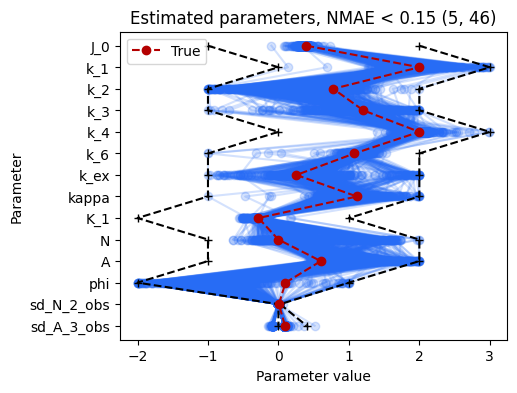

In [9]:
n_success = sum([f < threshold for f in pypesto_result.optimize_result.fval])
print(n_success)

if n_success < 5:
    colors = [39/255, 108/255, 245/255, 0.8]
else:
    colors = [39/255, 108/255, 245/255, 0.2]

pypesto.visualize.parameters(pypesto_result, size=(5, 4), start_indices=list(range(n_success)), reference=ref, colors=colors)
plt.title(f"Estimated parameters, NMAE < {threshold} ({noise}, {ndp})")
plt.savefig(dir_output / f"parameters_success_{metric}_{str(threshold).replace('.', '_')}.svg")

### Show the best train loss model

In [10]:
# test loss of the model with the best training loss
test_loss_best_train = df.sort_values(by="negLL_obs_trainval")["nmae_obs_test"].iloc[0]
# pypesto result index of the best training model
i_best_train = sum([i < test_loss_best_train for i in pypesto_result.optimize_result.fval])
assert pypesto_result.optimize_result[i_best_train].fval == test_loss_best_train

Text(0.5, 1.0, 'Estimated parameters, NMAE < 0.15 (5, 46)')

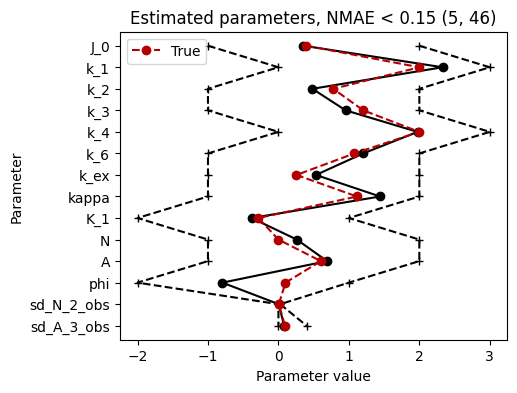

In [11]:
pypesto.visualize.parameters(pypesto_result, size=(5, 4), start_indices=[i_best_train], reference=ref, colors=[0, 0, 0, 1])
plt.title(f"Estimated parameters, NMAE < {threshold} ({noise}, {ndp})")

### Compare regularisation-dependent parameter estimation error by data set

In [12]:
noise_levels = [5, 10, 20, 35]
datapoint_levels = [8, 16, 31, 46, 61]

In [14]:
noise = 5
ndp = 8

res = {
    5: {
        ndp: pd.read_csv(f"5_{ndp}/best_train.csv")[['regbin', 'λ_reg', 'param_est_error']] 
        for ndp in datapoint_levels
    },
    10: {
        ndp: pd.read_csv(f"10_{ndp}/best_train.csv")[['regbin', 'λ_reg', 'param_est_error']] 
        for ndp in datapoint_levels
    },
    20: {
        ndp: pd.read_csv(f"20_{ndp}/best_train.csv")[['regbin', 'λ_reg', 'param_est_error']] 
        for ndp in datapoint_levels
    },
    35: {
        ndp: pd.read_csv(f"35_{ndp}/best_train.csv")[['regbin', 'λ_reg', 'param_est_error']] 
        for ndp in datapoint_levels
    },
}

/tmp/ipykernel_1186093/187015378.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1186093/187015378.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


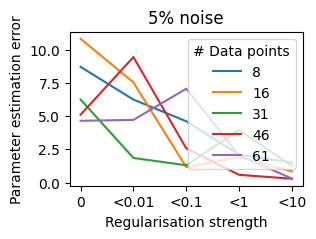

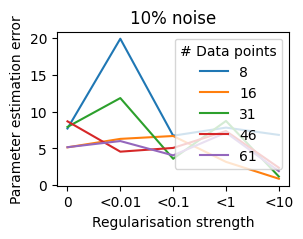

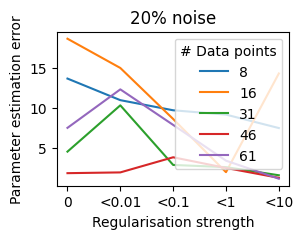

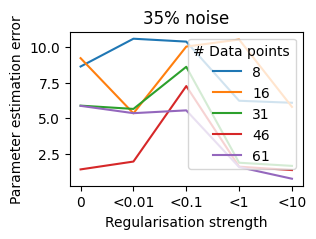

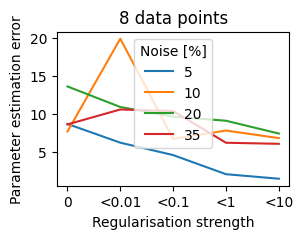

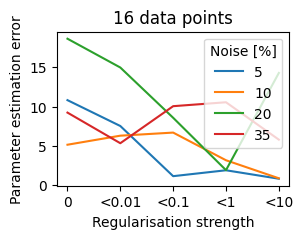

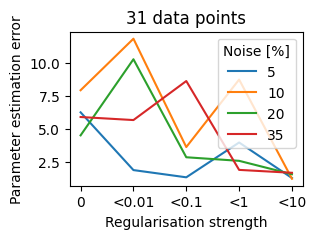

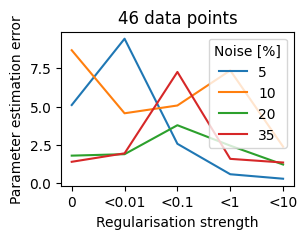

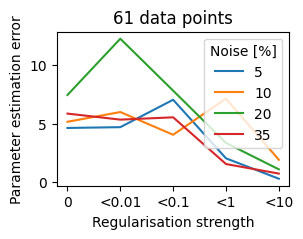

In [15]:
for noise, res_ in res.items():

    fig, ax = plt.subplots(figsize=(3, 2))
    ax.set_title(f"{noise}% noise")
    for ndp in datapoint_levels:
        ax.plot(res_[ndp]['regbin'], res_[ndp]['param_est_error'], label=ndp)
    ax.set_ylabel("Parameter estimation error")
    ax.set_xlabel("Regularisation strength")
    ax.legend(title="# Data points")
    fig.savefig(f"parameter_estimation_error/noise_{noise}.svg")
    fig.show()

for ndp in datapoint_levels:

    fig, ax = plt.subplots(figsize=(3, 2))
    ax.set_title(f"{ndp} data points")
    for noise in noise_levels:
        ax.plot(res[noise][ndp]['regbin'], res[noise][ndp]['param_est_error'], label=noise)
    ax.set_ylabel("Parameter estimation error")
    ax.set_xlabel("Regularisation strength")
    ax.legend(title="Noise [%]")
    fig.savefig(f"parameter_estimation_error/datapoints_{ndp}.svg")
    fig.show()